In [9]:
import pandas as pd
import numpy as np
from scipy import stats as sp
import sys, os
sys.path.append('../')
import trace_analysis
import plots_analysis
import trace_statistics
import trace_classification

# Data Preparation


Prepare the data to be used with kNN

In [10]:
plots = [("traces/normal/", 'grid9_normal_2019-02-13_17:05'),
         ("traces/1bh-3/", 'grid9_1bh-3_2019-02-13_16:28'),
         ("traces/1bh-5/", 'grid9_1bh-5_2019-02-13_15:31'),
         ("traces/1bh-6/", 'grid9_1bh-6_2019-02-13_12:59'),
         ("traces/1bh-7/", 'grid9_1bh-7_2019-02-13_15:08'),
         ("traces/1bh-9/", 'grid9_1bh-9_2019-02-13_15:57'),
         ("traces/1gh-3/", 'grid_1gh-5_2019-02-15_22:09'),
         ("traces/1gh-5/", 'grid_1gh-5_2019-02-15_22:09'),
         ("traces/1gh-6/", 'grid_1gh-6_2019-02-15_18:25'),
         ("traces/1gh-7/", 'grid9_1bh-7_2019-02-13_15:08'),
         ("traces/1gh-9/", 'grid_1gh-9_2019-02-15_19:19')
        ]

stats = None
win_25_stats = None
win_50_stats = None
win_100_stats = None

for row in plots:
    label = 'Normal'
    experiment = row[0].split('/')[1]
    
    # Assign a label
    if row[0].find('gh') >= 0 or row[0].find('bh') >= 0:
        label = 'Attacked'
    nodes, packets_node = trace_analysis.process_cooja2_traces(row[0], row[1])
    
    # Update stats
    if stats is None:
        stats = trace_statistics.compute_labeled_statistics(nodes, packets_node, label, experiment)
        win_25_stats = trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 25)
        win_50_stats = trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 50)
        win_100_stats = trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 100)
    else:
        stats = pd.concat([stats, trace_statistics.compute_labeled_statistics(nodes, packets_node, label, experiment)])
        win_25_stats = pd.concat([win_25_stats, trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 25)])
        win_50_stats = pd.concat([win_50_stats, trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 50)])
        win_100_stats = pd.concat([win_100_stats, trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 100)])
        
stats = stats.reset_index(drop=True)
win_25_stats = win_25_stats.reset_index(drop=True)
win_50_stats = win_50_stats.reset_index(drop=True)
win_100_stats = win_100_stats.reset_index(drop=True)

# Create a dictionary containing all the statistics for each trace size
trace_stats = {200: stats, 25: win_25_stats, 50: win_50_stats, 100: win_100_stats}
stats.head(5)

,node_id,experiment,count,mean,var,std,hop,min,max,loss,label
0,aaaa::212:7404:4:404:,normal,141,339.276596,85174.044377,291.845926,2,106.0,1563.0,0.295,Normal
1,aaaa::212:7405:5:505:,normal,178,392.123596,28083.058084,167.580005,3,197.0,1557.0,0.110,Normal
2,aaaa::212:7407:7:707:,normal,151,486.913907,68843.959205,262.381324,3,214.0,1623.0,0.245,Normal
3,aaaa::212:7406:6:606:,normal,176,315.613636,40342.752727,200.855054,2,129.0,1144.0,0.120,Normal
4,aaaa::212:740a:a:a0a:,normal,181,497.646409,66065.140945,257.031401,4,260.0,1945.0,0.095,Normal


# Feature Selection

Select the set of features and labels that we use to fit the algorithm

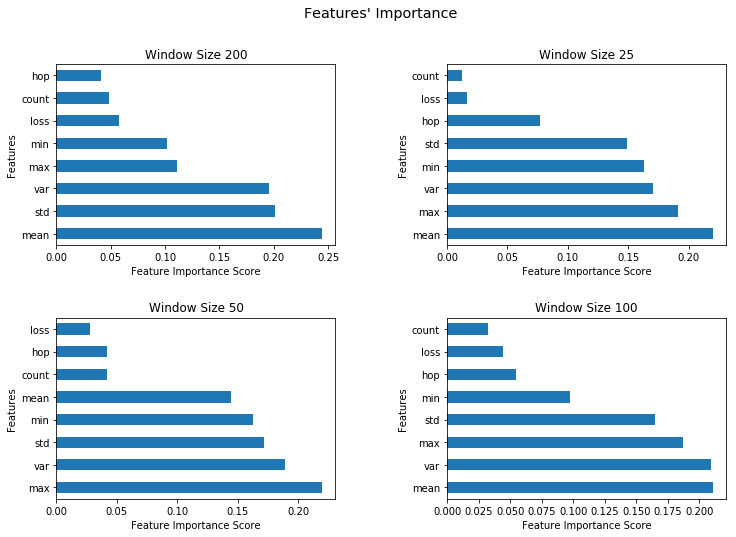

In [11]:
plots_analysis.random_forests_features_selection(trace_stats)

In [12]:
results = None            # Results from each classification algorithm
cv_results = None         # Cross validation results from each classification algorithm

features_to_drop = ['node_id', 'experiment', 'label', 'hop', 'loss', 'count']

# Random Forests Classifier

Let us experiment with random forests. First, let us select most relevant features.

In [13]:
results = pd.concat([results, 
                     trace_classification.random_forest_classification(trace_stats, features_to_drop)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


We want to compute average accuracy for each trace size (i.e. for each window size from 200 - the entire window - to 100, 50 and 25)

In [14]:
cv_results = pd.concat([cv_results, 
                     trace_classification.random_forest_cross_validation(trace_stats, features_to_drop)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


# K-Nearest Neighbor (KNN) Classification

Let us first observe the accuracies for different values of k

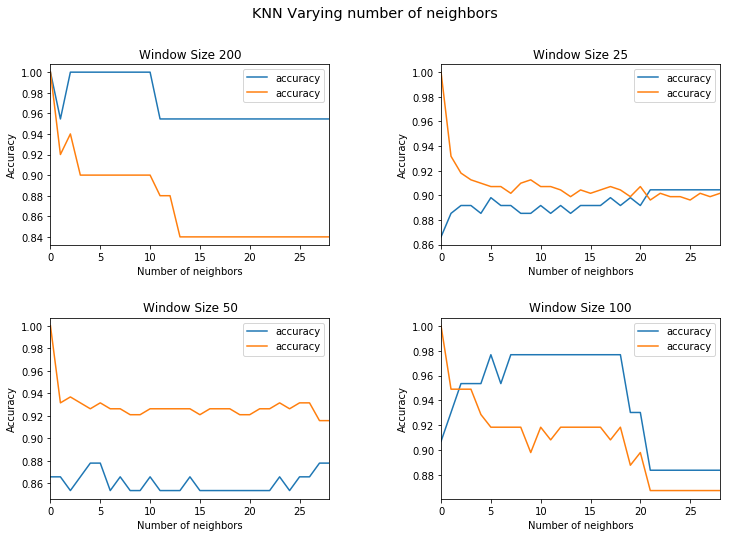

In [15]:
plots_analysis.knn_test_number_of_neighbors(trace_stats, 30)

Let's build KNN classifier 

In [16]:
results = pd.concat([results, 
                     trace_classification.k_nearest_neighbor_classification(trace_stats, features_to_drop, n_neighbors=30)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 

We want to compute average accuracy for each trace size (i.e. for each window size from 200 - the entire window - to 100, 50 and 25)

In [17]:
cv_results = pd.concat([cv_results, 
                     trace_classification.k_nearest_neighbor_cross_validation(trace_stats, features_to_drop, n_neighbors=30)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


# Support Vector Machines (SVM) Classification

Let us experiment with another classifier

In [18]:
results = pd.concat([results, 
                     trace_classification.support_vector_machines_classification(trace_stats, features_to_drop, kernel='linear')
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


We want to compute average accuracy for each trace size (i.e. for each window size from 200 - the entire window - to 100, 50 and 25)

In [19]:
cv_results = pd.concat([cv_results, 
                     trace_classification.support_vector_machines_cross_validation(trace_stats, features_to_drop, kernel='linear')
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


# One Vs The Rest Classifier

SVM performs really well, but it is slow. Now we try to implement it in a most efficient way. The strategy consists in fitting one classifier per class. For each classifier, the class is fitted against all the other classes

In [20]:
results = pd.concat([results, 
                     trace_classification.ensalble_svm_classification(trace_stats, features_to_drop, n_estimators=15)
                    ])

Computing trace 200
Computing trace 25


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Version

Computing trace 50


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Version

Computing trace 100


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Cross validate

In [21]:
cv_results = pd.concat([cv_results, 
                     trace_classification.ensalble_svm_cross_validation(trace_stats, features_to_drop, n_estimators=15)
                    ])

Computing trace 200


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Version

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Version

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Computing trace 25


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Version

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Version

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Version

Computing trace 50


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Version

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Version

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Version

Computing trace 100


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Version

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Version

# Results

Results from each model

In [39]:
results.reset_index(drop=True)

,Model,Window Size,Accuracy,Precision,Recall,F1-score,Time (ms)
0,Random Forest,200,1.000000,1.000000,1.000000,1.000000,0.088060
1,Random Forest,25,0.923567,0.790785,0.719249,0.748397,0.087016
2,Random Forest,50,0.890244,0.787281,0.667734,0.704682,0.085478
3,Random Forest,100,0.976744,0.987179,0.900000,0.937951,0.072102
4,KNN,200,0.954545,0.477273,0.500000,0.488372,0.009541
5,KNN,25,0.904459,0.718966,0.678873,0.696090,0.013078
6,KNN,50,0.878049,0.938272,0.545455,0.550439,0.006964
7,KNN,100,0.883721,0.441860,0.500000,0.469136,0.006776
8,SVM,200,1.000000,1.000000,1.000000,1.000000,2.364126
9,SVM,25,0.891720,0.697042,0.731455,0.712175,33.175365


Here we plot the average results for each model computed with cross validation

In [42]:
cv_results.reset_index(drop=True)

,Model,Window Size,Acuracy
0,Random Forest,200,0.932381
1,Random Forest,25,0.912175
2,Random Forest,50,0.915683
3,Random Forest,100,0.915709
4,KNN,200,0.876044
5,KNN,25,0.894940
6,KNN,50,0.904636
7,KNN,100,0.872797
8,SVM,200,0.919048
9,SVM,25,0.887320
